Student Name: Feiyang Li

Student ID: 23202564

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, transforms, Compose, Resize
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [4]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



```
model.train()
```
Set the model to training mode.  
```
X, y = X.to(device), y.to(device)
```
Move data and labels to the specified device. This is to accelerate computation.
```
pred = model(X)
```
Here the prediction pred is obtained by passing input data X through the model. this is the process of forward propagation.
```
loss = loss_fn(pred, y)
```
This line of code calculates the loss between the predicted result and the true label.
```
loss.backward()
```
This function performs the backward process. Compute the gradient of the loss function with respect to the model parameters.
```
optimizer.step()
```
This line of code updates the parameters of the model using the calculated gradient.
```
optimizer.zero_grad()
```
Before starting the next training batch, zero out the gradient in the model. This is because the gradient is cumulative by default.

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

100%|██████████| 26421880/26421880 [00:02<00:00, 12006516.61it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 177161.89it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3261627.62it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5347270.18it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



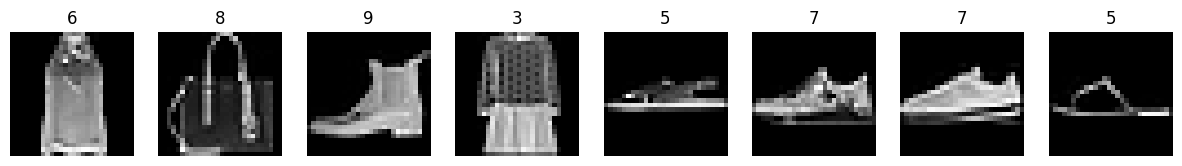

In [8]:
transforms = Compose([
    ToTensor(),
    Normalize((0.2859,), (0.3530,)),
    Resize((28, 28))
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms
)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

fig, ax = plt.subplots(figsize=(15, 7), ncols=8)
for i in range(8):
    ax[i].imshow(images[i].squeeze(), cmap='gray')
    ax[i].title.set_text(str(labels[i].item()))
    ax[i].axis('off')
plt.show()



---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)

summary(model, (1, 28*28))

x = torch.rand(1, 1, 28, 28, device=device)
logits = model(x)
print(logits)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------
tensor([[-0.0328,  0.0656,  0.0285,  0.0094, -0.1190,  0.0820, -0.0875, -0.0566,
         -0.0539,  0.0415]], device='cuda:0', grad_fn=<AddmmBackward0>)


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch 1
-------------------------------
loss: 2.344854  [    0/60000]
loss: 0.470851  [ 6400/60000]
loss: 0.345809  [12800/60000]
loss: 0.585174  [19200/60000]
loss: 0.276755  [25600/60000]
loss: 0.392847  [32000/60000]
loss: 0.520558  [38400/60000]
loss: 0.698638  [44800/60000]
loss: 0.443372  [51200/60000]
loss: 0.354000  [57600/60000]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.389992 

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.443905 

Epoch 2
-------------------------------
loss: 0.231655  [    0/60000]
loss: 0.218265  [ 6400/60000]
loss: 0.521223  [12800/60000]
loss: 0.358690  [19200/60000]
loss: 0.345396  [25600/60000]
loss: 0.439506  [32000/60000]
loss: 0.431562  [38400/60000]
loss: 0.426743  [44800/60000]
loss: 0.285248  [51200/60000]
loss: 0.249127  [57600/60000]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.299389 

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.365542 

Epoch 3
-------------------------------
loss: 0.231986  [    0/60000]
loss: 0.238292  [ 6400/60000]
loss: 0.3096

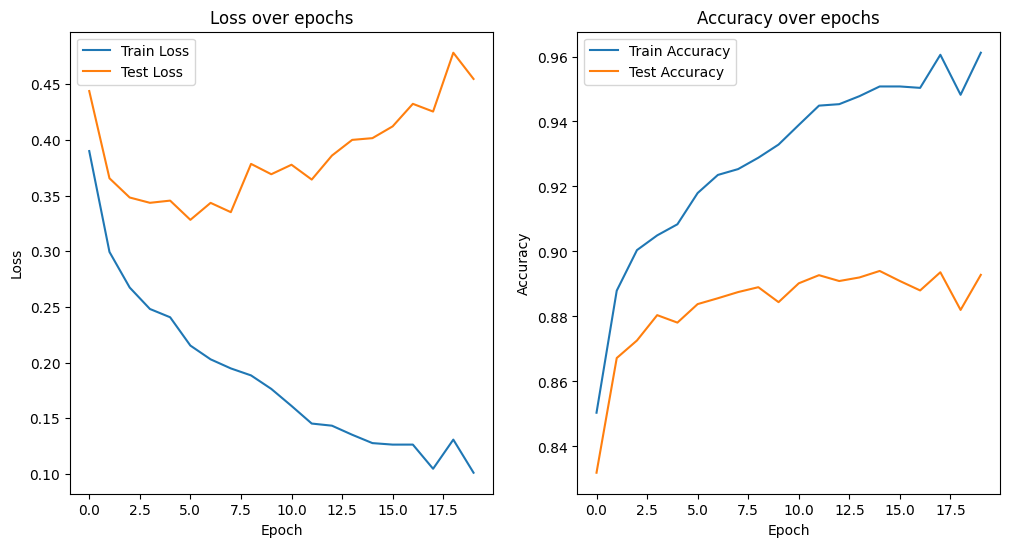

In [6]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    train_loss, train_accuracy = test_loop(train_loader, model, loss_fn)
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

在左侧的损失图中：

训练损失（蓝色线）随着epoch增加而持续下降，这表明模型在训练数据上的表现越来越好。
测试损失（橙色线）最初下降，但在大约5个epoch后开始上升，这是过拟合的一个典型迹象。过拟合发生时，模型在训练数据上表现很好，但在未见过的测试数据上表现不佳。
在右侧的准确率图中：

训练准确率（蓝色线）稳步上升，几乎接近96%，这显示模型在识别训练集中的图像方面越来越精确。
测试准确率（橙色线）在一开始也随着epoch的增加而提高，但在大约7个epoch之后，准确率趋于平稳甚至略有下降，这也可能指示模型在测试数据上开始过拟合。


---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

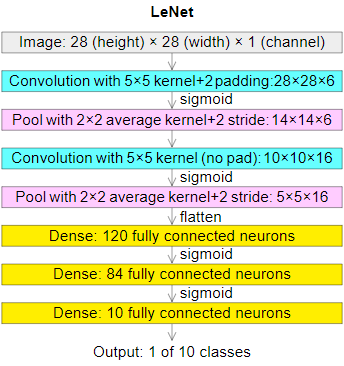

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),  # Convolution 1
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),      # Pooling 1
            nn.Conv2d(6, 16, kernel_size=5),            # Convolution 2
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),      # Pooling 2
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),                 # Dense 1
            nn.Sigmoid(),
            nn.Linear(120, 84),                         # Dense 2
            nn.Sigmoid(),
            nn.Linear(84, 10)                           # Output layer
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
def train_model(model, train_loader, criterion, optimizer, n_epochs=20):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        test_loss, test_accuracy = test_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return total_loss / len(test_loader), correct / total


In [10]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, test_losses, 'b', label='Testing loss')
    plt.title('Training and Testing loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'b', label='Testing accuracy')
    plt.title('Training and Testing accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/20, Train Loss: 1.1327, Train Accuracy: 0.5796, Test Loss: 0.7430, Test Accuracy: 0.7232
Epoch 2/20, Train Loss: 0.6479, Train Accuracy: 0.7513, Test Loss: 0.6182, Test Accuracy: 0.7550
Epoch 3/20, Train Loss: 0.5499, Train Accuracy: 0.7890, Test Loss: 0.5681, Test Accuracy: 0.7784
Epoch 4/20, Train Loss: 0.4982, Train Accuracy: 0.8122, Test Loss: 0.4946, Test Accuracy: 0.8127
Epoch 5/20, Train Loss: 0.4618, Train Accuracy: 0.8296, Test Loss: 0.4728, Test Accuracy: 0.8248
Epoch 6/20, Train Loss: 0.4387, Train Accuracy: 0.8381, Test Loss: 0.4667, Test Accuracy: 0.8238
Epoch 7/20, Train Loss: 0.4197, Train Accuracy: 0.8459, Test Loss: 0.4358, Test Accuracy: 0.8384
Epoch 8/20, Train Loss: 0.4055, Train Accuracy: 0.8518, Test Loss: 0.4180, Test Accuracy: 0.8469
Epoch 9/20, Train Loss: 0.3925, Train Accuracy: 0.8550, Test Loss: 0.4094, Test Accuracy: 0.8497
Epoch 10/20, Train Loss: 0.3794, Train Accuracy: 0.8605, Test Loss: 0.3952, Test Accuracy: 0.8536
Epoch 11/20, Train Loss: 0.36

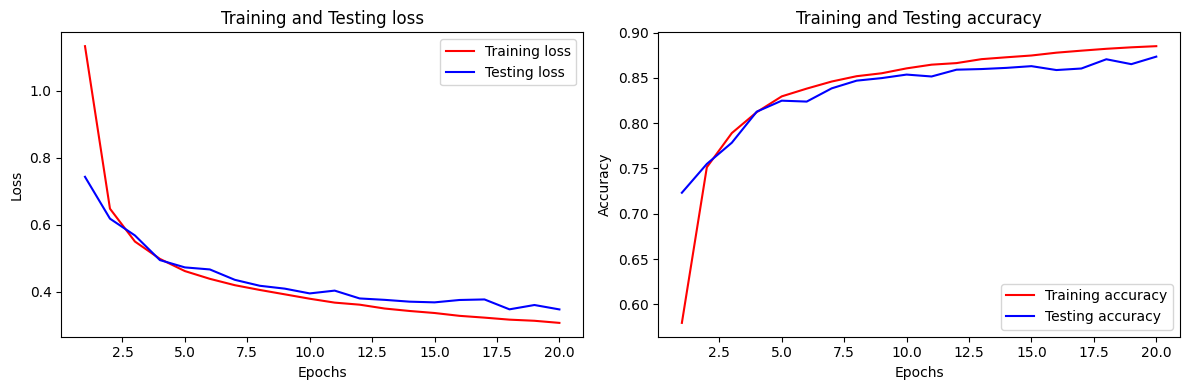

In [13]:
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, criterion, optimizer)
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

**Number of parameters**: convolutional neural networks usually have fewer parameters due to their shared weights nature. In a fully connected network, each input node needs to be connected to each node in the next layer, which can lead to a rapid increase in the number of parameters. In contrast, the convolutional layer in LeNet significantly reduces the number of parameters by sharing weights through filters.    

**Performannce**: Convolutional neural networks tend to perform better in image recognition tasks due to the ability of the convolutional layer to capture local features in the image. Fully connected models may not be able to effectively handle spatial hierarchies in images, which is important for image recognition tasks.  
  
**Overfitting**: the risk of overfitting is higher in models with a large number of parameters, as the model may learn noise in the training data instead of the underlying data distribution.LeNet may show better generalisation on equivalent datasets due to fewer parameters and the spatial filtering properties of the convolutional layer. Fully connected networks may require more regularisation techniques or data augmentation to resist overfitting.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch 1/20, Train Loss: 0.5615, Train Accuracy: 0.7925, Test Loss: 0.3947, Test Accuracy: 0.8565
Epoch 2/20, Train Loss: 0.3534, Train Accuracy: 0.8701, Test Loss: 0.3499, Test Accuracy: 0.8704
Epoch 3/20, Train Loss: 0.3074, Train Accuracy: 0.8874, Test Loss: 0.3433, Test Accuracy: 0.8765
Epoch 4/20, Train Loss: 0.2787, Train Accuracy: 0.8971, Test Loss: 0.3130, Test Accuracy: 0.8866
Epoch 5/20, Train Loss: 0.2580, Train Accuracy: 0.9037, Test Loss: 0.3039, Test Accuracy: 0.8894
Epoch 6/20, Train Loss: 0.2421, Train Accuracy: 0.9106, Test Loss: 0.3195, Test Accuracy: 0.8893
Epoch 7/20, Train Loss: 0.2249, Train Accuracy: 0.9160, Test Loss: 0.2813, Test Accuracy: 0.9002
Epoch 8/20, Train Loss: 0.2128, Train Accuracy: 0.9203, Test Loss: 0.2698, Test Accuracy: 0.9035
Epoch 9/20, Train Loss: 0.2016, Train Accuracy: 0.9240, Test Loss: 0.2858, Test Accuracy: 0.9009
Epoch 10/20, Train Loss: 0.1867, Train Accuracy: 0.9295, Test Loss: 0.2752, Test Accuracy: 0.8998
Epoch 11/20, Train Loss: 0.17

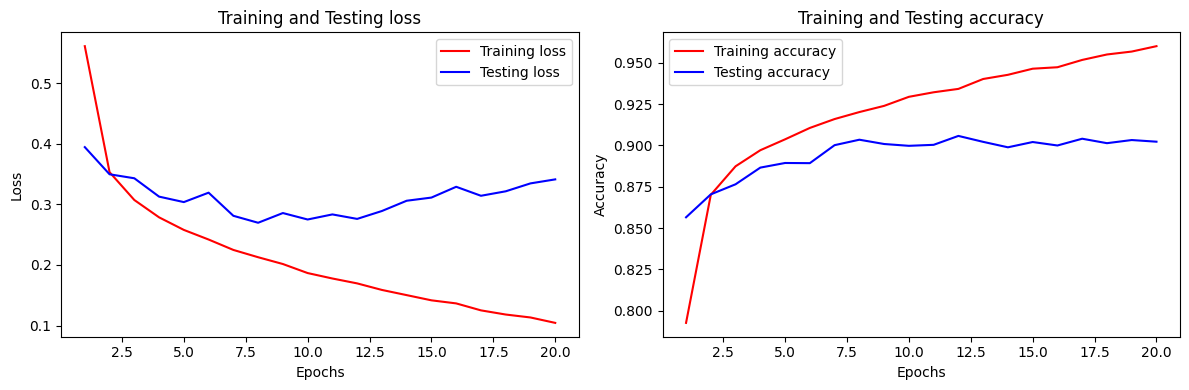

In [14]:
class ModernLeNet(nn.Module):
    def __init__(self):
        super(ModernLeNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),  # Convolution 1
            nn.ReLU(),                                 # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),     # Max Pooling 1
            nn.Conv2d(6, 16, kernel_size=5),           # Convolution 2
            nn.ReLU(),                                 # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),     # Max Pooling 2
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),                # Dense 1
            nn.ReLU(),                                 # ReLU activation
            nn.Linear(120, 84),                        # Dense 2
            nn.ReLU(),                                 # ReLU activation
            nn.Linear(84, 10)                          # Output layer
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.fc(x)
        return x


model = ModernLeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, criterion, optimizer)

plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

I replaced the Sigmoid activation function in the original LeNet model with ReLU and replaced the average pooling layer with a maximum pooling layer. Training and mapping use the same functions as before.

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

**Performance**: models using ReLU and maximum pooling layers may learn faster and converge to better performance.  

**Overfitting**: although ReLU can speed up training, it may also lead to faster overfitting, especially if there is not enough regularisation or data augmentation.  

**Number of parameters**: the number of parameters does not change as a result of changes to the activation function or pooling layer, as these operations do not increase the model parameters.**加粗文字**

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch 1/20, Train Loss: 0.3045, Train Accuracy: 0.8899, Test Loss: 0.2591, Test Accuracy: 0.9045
Epoch 2/20, Train Loss: 0.2160, Train Accuracy: 0.9197, Test Loss: 0.2338, Test Accuracy: 0.9146
Epoch 3/20, Train Loss: 0.1679, Train Accuracy: 0.9376, Test Loss: 0.2081, Test Accuracy: 0.9262
Epoch 4/20, Train Loss: 0.1373, Train Accuracy: 0.9485, Test Loss: 0.2241, Test Accuracy: 0.9225
Epoch 5/20, Train Loss: 0.1090, Train Accuracy: 0.9590, Test Loss: 0.2065, Test Accuracy: 0.9305
Epoch 6/20, Train Loss: 0.0853, Train Accuracy: 0.9684, Test Loss: 0.2577, Test Accuracy: 0.9223
Epoch 7/20, Train Loss: 0.0675, Train Accuracy: 0.9743, Test Loss: 0.2651, Test Accuracy: 0.9251
Epoch 8/20, Train Loss: 0.0534, Train Accuracy: 0.9804, Test Loss: 0.2842, Test Accuracy: 0.9267
Epoch 9/20, Train Loss: 0.0434, Train Accuracy: 0.9839, Test Loss: 0.3146, Test Accuracy: 0.9219
Epoch 10/20, Train Loss: 0.0385, Train Accuracy: 0.9859, Test Loss: 0.3301, Test Accuracy: 0.9301
Epoch 11/20, Train Loss: 0.03

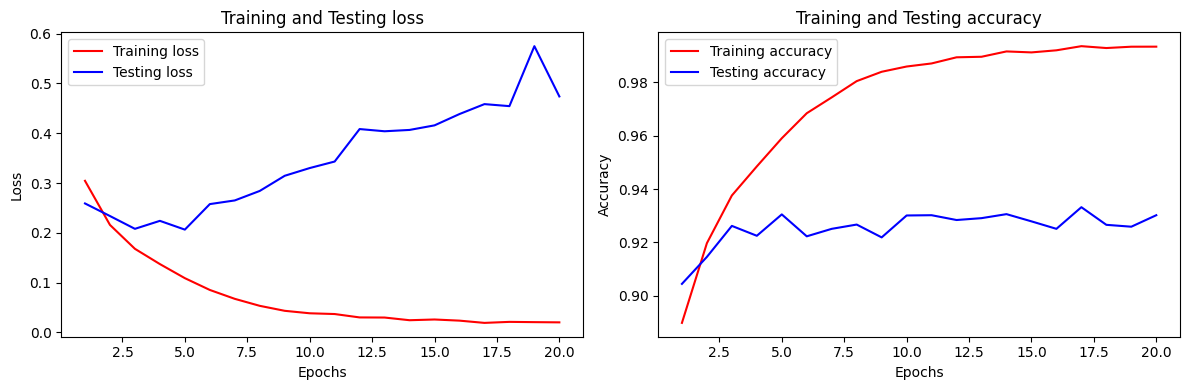

In [11]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Convolution 1
            nn.BatchNorm2d(32),                         # Batch Normalization
            nn.ReLU(),                                  # ReLU activation
            nn.Conv2d(32, 32, kernel_size=3, padding=1),# Convolution 2
            nn.BatchNorm2d(32),                         # Batch Normalization
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),      # Max Pooling 1
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# Convolution 3
            nn.BatchNorm2d(64),                         # Batch Normalization
            nn.ReLU(),                                  # ReLU activation
            nn.Conv2d(64, 64, kernel_size=3, padding=1),# Convolution 4
            nn.BatchNorm2d(64),                         # Batch Normalization
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),      # Max Pooling 2
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),                 # Dense 1
            nn.BatchNorm1d(256),                        # Batch Normalization
            nn.ReLU(),                                  # ReLU activation
            nn.Linear(256, 10),                         # Output layer
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = MyCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, criterion, optimizer)
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [14]:
from torchvision import transforms as T

In [18]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=T.Compose([
        T.Resize((224,224)),
        T.Grayscale(3),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([
        T.Resize((224,224)),
        T.Grayscale(3),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

1.

Epoch [1/5], Loss: 0.4159, Accuracy: 0.8488
Epoch [2/5], Loss: 0.2560, Accuracy: 0.9059
Epoch [3/5], Loss: 0.2119, Accuracy: 0.9229
Epoch [4/5], Loss: 0.1777, Accuracy: 0.9359
Epoch [5/5], Loss: 0.1461, Accuracy: 0.9473
Test Accuracy: 0.9081


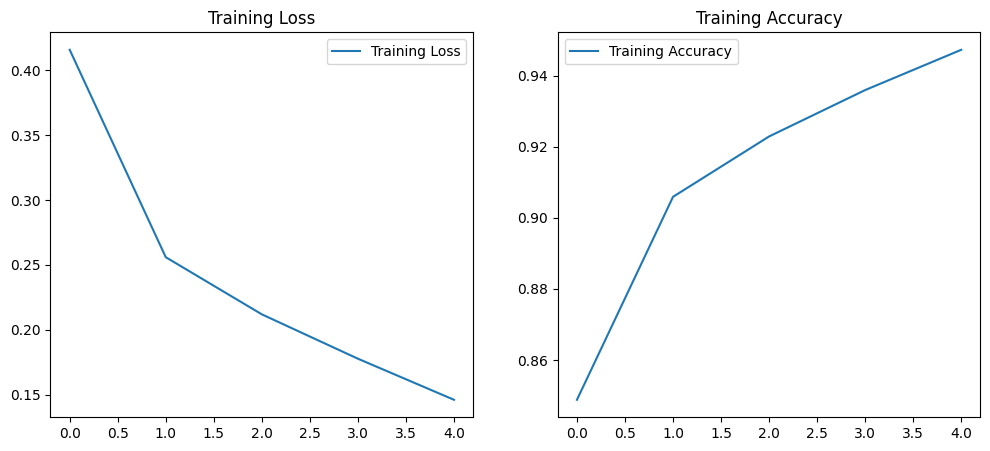

In [30]:
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, dataloader, loss_fn, optimizer, epochs):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / len(dataloader.dataset)
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, train_accuracies

def test_model(model, dataloader):
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / len(dataloader.dataset)
    return accuracy

epochs = 5
train_losses, train_accuracies = train_model(model, train_dataloader, loss_fn, optimizer, epochs)

test_accuracy = test_model(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


2.

Epoch [1/5], Loss: 0.3005, Accuracy: 0.8911
Epoch [2/5], Loss: 0.2009, Accuracy: 0.9264
Epoch [3/5], Loss: 0.1569, Accuracy: 0.9430
Epoch [4/5], Loss: 0.1257, Accuracy: 0.9535
Epoch [5/5], Loss: 0.0979, Accuracy: 0.9632
Test Accuracy: 0.9146


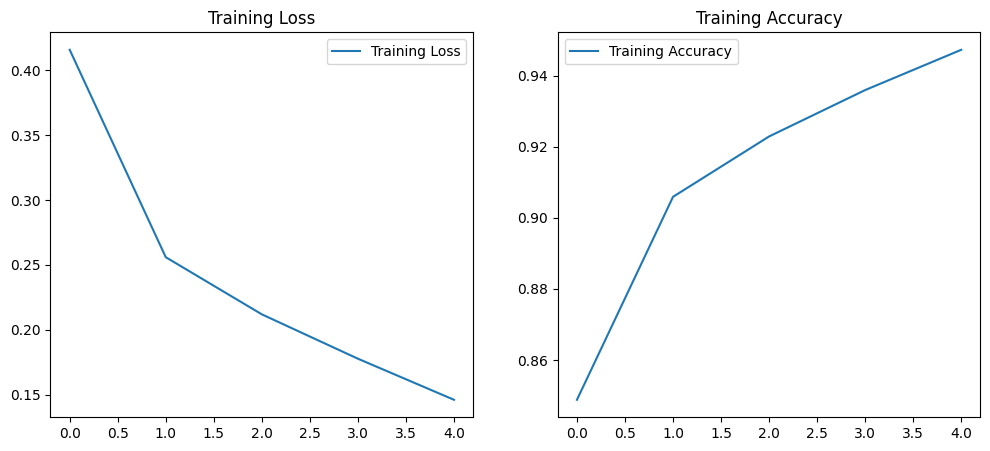

In [32]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5
train_model(model, train_dataloader, loss_fn, optimizer, num_epochs)
test_accuracy = test_model(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

3.

Epoch [1/5], Loss: 0.0901, Accuracy: 0.9668
Epoch [2/5], Loss: 0.0855, Accuracy: 0.9686
Epoch [3/5], Loss: 0.0836, Accuracy: 0.9693
Epoch [4/5], Loss: 0.0823, Accuracy: 0.9701
Epoch [5/5], Loss: 0.0813, Accuracy: 0.9705
Test Accuracy: 0.9359


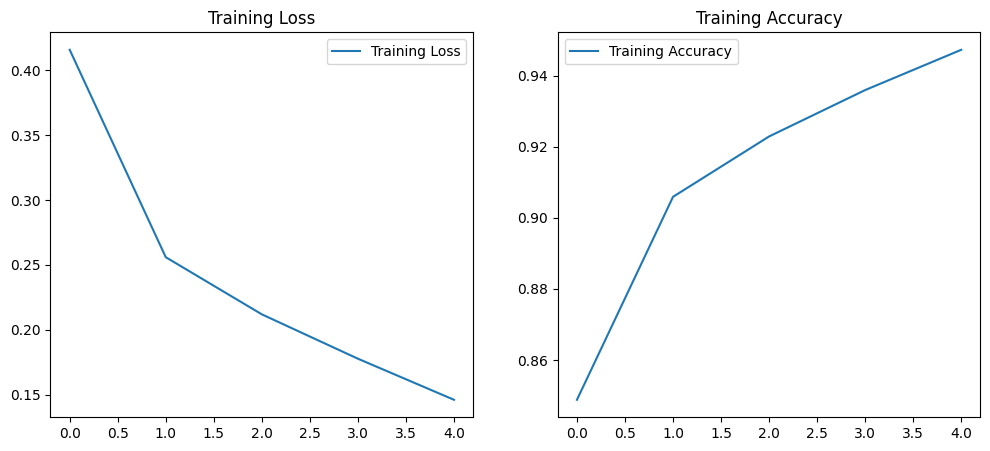

In [33]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 5
train_model(model, train_dataloader, loss_fn, optimizer, num_epochs)
test_accuracy = test_model(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

**Using randomly initialised weights**: in this approach, we train the entire ResNet18 model from scratch without utilising any pre-trained weights. This means that all the weights are randomly initialised and the model has to learn to extract features from the data. This approach usually takes longer training time, requires more data to avoid overfitting, and may struggle to achieve high accuracy with smaller datasets or limited computational resources.

**Using pre-trained weights**: this method utilises the weights pre-trained by ResNet18 on large datasets such as ImageNet. Since these weights are already capable of recognising a wide range of features, the model is trained by simply adapting the final classification layer to the new task. This approach speeds up the training process and typically achieves high accuracy rates, even on relatively small datasets.

**Freezing most of the layers of the pre-trained model**: in the third approach, we keep the weights of all layers of the pre-trained model unchanged except for the last one, and train only the last fully connected layer. The reason for this is that the pre-trained layers are already capable of extracting effective features, and we only need to adjust the output of the model to the new task. This approach further reduces training time and prevents overfitting as a large number of weights do not change.